In [20]:
from functools import partial
import hashlib

import datasets
from dotenv import load_dotenv
import tiktoken
import torch
import vec2text 
from transformers import AutoTokenizer, AutoModelForCausalLM

load_dotenv()

def compute_cosine_similarity(embeddings1, embeddings2):
    return torch.nn.functional.cosine_similarity(embeddings1, embeddings2, dim=0)


## Setup for error analysis

Let's take the first $n=100$ rows of the precomputed val dataset for MS MARCO.

In [2]:
N_SAMPLES=100
dataset = datasets.load_dataset("jxm/msmarco__openai_ada2")
dataset = dataset["train"].select(range(N_SAMPLES))

In [5]:
MAX_LENGTH=128
HF_MODEL_ID='thesephist/contra-bottleneck-t5-large-wikipedia'

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_ID, model_max_length=MAX_LENGTH)

def truncate_text(example):
    text_tokens = tokenizer(example["text"])['input_ids']
    text_tokens = [passage[:MAX_LENGTH] for passage in text_tokens]
    text_list = tokenizer.batch_decode(text_tokens)
    example["text"] = text_list
    return example

In [6]:
dataset = dataset.map(truncate_text, batched=True, batch_size=1024, num_proc=12)

Map (num_proc=12):   0%|          | 0/100 [00:00<?, ? examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (147 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (163 > 128). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (147 > 128). Running this sequence through the model will result in indexing errors
Map (num_proc=12): 100%|██████████| 100/100 [00:00<00:00, 596.79 examples/s]


In [7]:
# Assumes no batching
def get_text_hash(example):
    example["source_id"] = hashlib.md5(example["text"].encode()).hexdigest()
    return example
    

dataset = dataset.map(get_text_hash, batched=False, num_proc=12)

Map (num_proc=12): 100%|██████████| 100/100 [00:00<00:00, 721.75 examples/s]


In [8]:
dataset = dataset.add_column(name="sim", column=[1] * N_SAMPLES)

## Generating samples

In [9]:
class BottleneckT5Autoencoder:
    def __init__(self, model_path: str, device='cpu'):
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, model_max_length=512)
        self.model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True).to(self.device)
        self.model.eval()

    @torch.no_grad()
    def embed(self, text: str) -> torch.FloatTensor:
        inputs = self.tokenizer(text, return_tensors='pt').to(self.device)
        decoder_inputs = self.tokenizer('', return_tensors='pt').to(self.device)
        return self.model(
            **inputs,
            decoder_input_ids=decoder_inputs['input_ids'],
            encode_only=True,
        )[0]

    @torch.no_grad()
    def generate_from_latent(self, latent: torch.FloatTensor, max_length=512, temperature=1.0) -> str:
        dummy_text = '.'
        dummy = self.embed(dummy_text)
        perturb_vector = latent - dummy
        self.model.perturb_vector = perturb_vector
        input_ids = self.tokenizer(dummy_text, return_tensors='pt').to(self.device).input_ids
        output = self.model.generate(
            input_ids=input_ids,
            max_length=max_length,
            do_sample=True,
            temperature=temperature,
            top_p=0.9,
            num_return_sequences=1,
        )
        return self.tokenizer.decode(output[0], skip_special_tokens=True)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = BottleneckT5Autoencoder(model_path=HF_MODEL_ID, device=device)

A new version of the following files was downloaded from https://huggingface.co/thesephist/contra-bottleneck-t5-large-wikipedia:
- bottleneck_t5.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


In [22]:
# Get prediction trajectory at n_steps=10 
# Assume non-batched
def get_reconstruction(example):
    original_embedding = autoencoder.embed(example["text"])
    reconstructed_text = autoencoder.generate_from_latent(original_embedding)
    reencoded_embedding = autoencoder.embed(reconstructed_text)

    example["embeddings_A"] = original_embedding
    example["embeddings_B"] = reencoded_embedding
    example["pred"] = reconstructed_text

    # Append to example
    example["sim"] = compute_cosine_similarity(original_embedding, reencoded_embedding).item()

    return example


In [25]:
test_dataset = dataset.select(range(100)).map(get_reconstruction, batched=False)

Map: 100%|██████████| 100/100 [02:10<00:00,  1.31s/ examples]


In [29]:
from nltk.translate.bleu_score import sentence_bleu

test_dataset = test_dataset.select(range(100)).map(lambda example: {**example, "bleu": sentence_bleu([example["text"].split()], example["pred"].split())})

Map:   0%|          | 0/100 [00:00<?, ? examples/s]/home/ritsuko/ai/nlp/vec2text/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ritsuko/ai/nlp/vec2text/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Map: 100%|██████████| 100/100 [00:00<00:00, 1288.19 examples/s]


In [30]:
#test_dataset.to_csv('test.csv', index=False)
test_dataset.remove_columns(['embeddings_A', 'embeddings_B']).to_csv("test_contra_no_emb.csv", index=False)

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 95.38ba/s]


68472

## Analysis

In [31]:
import pandas as pd

df = pd.read_csv("./test_contra_no_emb.csv")

In [32]:
df["sim"].describe()

count    100.000000
mean       0.865752
std        0.045463
min        0.754061
25%        0.829604
50%        0.865126
75%        0.901161
max        0.985207
Name: sim, dtype: float64

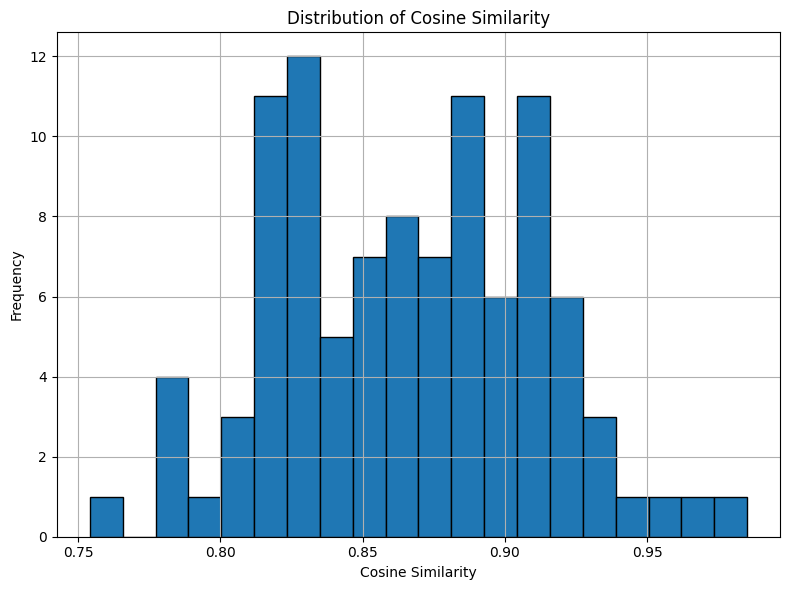

In [34]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram
ax.hist(df['sim'], bins=20, edgecolor='black')

# Set labels and title
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Cosine Similarity')

# Adjust the x-axis limits to zoom in on the range of values
#ax.set_xlim(0.95, 1.0)

# Add grid lines
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

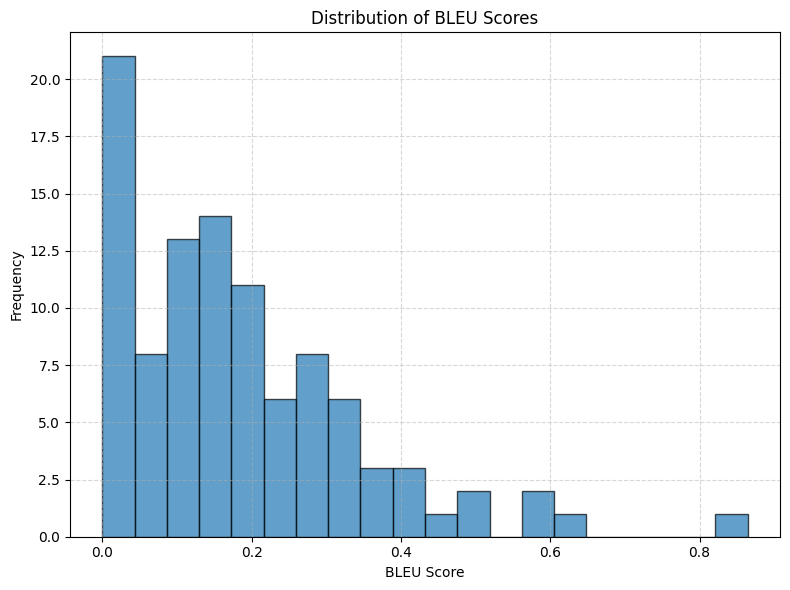

In [35]:
# Assuming you have the BLEU scores in a DataFrame column called 'bleu'
bleu_scores = df['bleu']

# Create a histogram of the BLEU scores
plt.figure(figsize=(8, 6))
plt.hist(bleu_scores, bins=20, edgecolor='black', alpha=0.7)

# Set labels and title
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()

In [36]:
df["bleu"].describe()

count     1.000000e+02
mean      1.818064e-01
std       1.630327e-01
min      3.851114e-155
25%       7.848437e-02
50%       1.477573e-01
75%       2.700531e-01
max       8.645707e-01
Name: bleu, dtype: float64